In [1]:
import datetime
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

from model import build_encoder, build_autoencoder
from data import example_to_tensor, normalize, add_channel_axis, train_test_split
from utils import duplicate_iterator, plot_slice, plot_animated_volume
from config import allocate_gpu_memory_only_when_needed, data_root_dir, seed

%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

In [2]:
# from tensorflow.keras.mixed_precision import experimental as mixed_precision
#
# policy = mixed_precision.Policy("mixed_float16")
##policy = mixed_precision.Policy("float32")
# mixed_precision.set_policy(policy)
# print("Compute dtype: %s" % policy.compute_dtype)
# print("Variable dtype: %s" % policy.variable_dtype)

In [3]:
downscaling = 4
if downscaling == 4:
    input_shape = (24, 128, 128, 1)
    tfrecord_glob = "CT-[0-4]-0.25/*.tfrecord"
elif downscaling == 2:
    input_shape = (48, 256, 256, 1)
    tfrecord_glob = "CT-[0-4]-0.5/*.tfrecord"
elif downscaling == 1:
    input_shape = (96, 512, 512, 1)
    tfrecord_glob = "CT-[0-4]/*.tfrecord"
else:
    raise RuntimeError("Downscaling not supported")

encoder_num_filters = [64]
epochs = 1000
patience = 20
batch_size = 8
learning_rate = 0.0001
val_perc = 0.2

In [4]:
tfrecord_fnames = [str(p) for p in Path(data_root_dir).glob(tfrecord_glob)]
dataset = (
    tf.data.TFRecordDataset(tfrecord_fnames)
    .map(example_to_tensor, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(add_channel_axis, num_parallel_calls=tf.data.experimental.AUTOTUNE)
)
num_samples = sum(1 for _ in dataset)
# num_samples = 1110   # CT-[0-4]
print(f"Number of samples: {num_samples}")
dataset

Number of samples: 1110


<ParallelMapDataset shapes: (None, None, None, 1), types: tf.float32>

In [5]:
unsupervised_train_ds, unsupervised_val_ds = train_test_split(
    dataset,
    test_perc=val_perc,
    cardinality=num_samples,
    seed=seed,
)
unsupervised_val_ds = unsupervised_val_ds.padded_batch(batch_size, input_shape)
val_ds_gen = duplicate_iterator(unsupervised_val_ds)
unsupervised_val_ds = (
    tf.data.Dataset.from_generator(lambda: val_ds_gen, (tf.float32, tf.float32))
    .cache()
    .prefetch(tf.data.experimental.AUTOTUNE)
)
unsupervised_train_ds = unsupervised_train_ds.padded_batch(batch_size, input_shape)
train_ds_gen = duplicate_iterator(unsupervised_train_ds)
unsupervised_train_ds = (
    tf.data.Dataset.from_generator(lambda: train_ds_gen, (tf.float32, tf.float32))
    .cache()  # must be called before shuffle
    .shuffle(buffer_size=64, reshuffle_each_iteration=True)
    .prefetch(tf.data.experimental.AUTOTUNE)
)
unsupervised_train_ds

<PrefetchDataset shapes: (<unknown>, <unknown>), types: (tf.float32, tf.float32)>

In [6]:
autoencoder = build_autoencoder(input_shape, encoder_num_filters)
autoencoder.get_layer("encoder").summary()
autoencoder.get_layer("decoder").summary()
autoencoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24, 128, 128, 1)] 0         
_________________________________________________________________
conv3d (Conv3D)              (None, 24, 128, 128, 64)  1792      
_________________________________________________________________
alpha_dropout (AlphaDropout) (None, 24, 128, 128, 64)  0         
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 12, 64, 64, 64)    0         
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 12, 64, 64, 64)]  0         
________________________________________

In [ ]:
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.MeanSquaredError(),
)

start_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
best_checkpoint = f"models/autoencoder-{start_time}.h5"
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    best_checkpoint, monitor="val_loss", verbose=1, save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=patience,
)
log_dir = f"logs/autoencoder-{start_time}"
file_writer = tf.summary.create_file_writer(log_dir)
tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=False,
    profile_batch=0,
)
autoencoder.fit(
    unsupervised_train_ds,
    validation_data=unsupervised_val_ds,
    epochs=epochs,
    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb],
)
with file_writer.as_default():
    tf.summary.text(
        "Hyperparameters",
        f"{downscaling=}; "
        f"{encoder_num_filters=}; "
        f"{epochs=}; "
        f"{patience=}; "
        f"{batch_size=}; "
        f"{learning_rate=}; "
        f"{val_perc=}",
        step=0,
    )
autoencoder = keras.models.load_model(best_checkpoint)

Epoch 1/1000
    111/Unknown - 41s 367ms/step - loss: 0.0200
Epoch 00001: val_loss improved from inf to 0.00587, saving model to models/autoencoder-20201023-200127.h5
111/111 [==============================] - 45s 408ms/step - loss: 0.0200 - val_loss: 0.0059
Epoch 2/1000
111/111 [==============================] - ETA: 0s - loss: 0.0058
Epoch 00002: val_loss improved from 0.00587 to 0.00430, saving model to models/autoencoder-20201023-200127.h5
111/111 [==============================] - 44s 396ms/step - loss: 0.0058 - val_loss: 0.0043
Epoch 3/1000
111/111 [==============================] - ETA: 0s - loss: 0.0044
Epoch 00003: val_loss improved from 0.00430 to 0.00382, saving model to models/autoencoder-20201023-200127.h5
111/111 [==============================] - 44s 397ms/step - loss: 0.0044 - val_loss: 0.0038
Epoch 4/1000
111/111 [==============================] - ETA: 0s - loss: 0.0039
Epoch 00004: val_loss improved from 0.00382 to 0.00352, saving model to models/autoencoder-20201023-

Epoch 31/1000
111/111 [==============================] - ETA: 0s - loss: 0.0016
Epoch 00031: val_loss improved from 0.00174 to 0.00167, saving model to models/autoencoder-20201023-200127.h5
111/111 [==============================] - 44s 396ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 32/1000
111/111 [==============================] - ETA: 0s - loss: 0.0016
Epoch 00032: val_loss improved from 0.00167 to 0.00164, saving model to models/autoencoder-20201023-200127.h5
111/111 [==============================] - 44s 395ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 33/1000
111/111 [==============================] - ETA: 0s - loss: 0.0016
Epoch 00033: val_loss did not improve from 0.00164
111/111 [==============================] - 44s 394ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 34/1000
111/111 [==============================] - ETA: 0s - loss: 0.0015
Epoch 00034: val_loss improved from 0.00164 to 0.00160, saving model to models/autoencoder-20201023-200127.h5
111/111 [==============

Epoch 62/1000
111/111 [==============================] - ETA: 0s - loss: 0.0010
Epoch 00062: val_loss improved from 0.00111 to 0.00109, saving model to models/autoencoder-20201023-200127.h5
111/111 [==============================] - 44s 396ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 63/1000
111/111 [==============================] - ETA: 0s - loss: 0.0010
Epoch 00063: val_loss improved from 0.00109 to 0.00109, saving model to models/autoencoder-20201023-200127.h5
111/111 [==============================] - 44s 396ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 64/1000
111/111 [==============================] - ETA: 0s - loss: 0.0010
Epoch 00064: val_loss improved from 0.00109 to 0.00109, saving model to models/autoencoder-20201023-200127.h5
111/111 [==============================] - 44s 396ms/step - loss: 0.0010 - val_loss: 0.0011
Epoch 65/1000
111/111 [==============================] - ETA: 0s - loss: 0.0010
Epoch 00065: val_loss did not improve from 0.00109
111/111 [==============

111/111 [==============================] - ETA: 0s - loss: 7.9469e-04
Epoch 00092: val_loss improved from 0.00084 to 0.00084, saving model to models/autoencoder-20201023-200127.h5
111/111 [==============================] - 44s 396ms/step - loss: 7.9469e-04 - val_loss: 8.3881e-04
Epoch 93/1000
111/111 [==============================] - ETA: 0s - loss: 7.8892e-04
Epoch 00093: val_loss did not improve from 0.00084
111/111 [==============================] - 44s 394ms/step - loss: 7.8892e-04 - val_loss: 8.5092e-04
Epoch 94/1000
111/111 [==============================] - ETA: 0s - loss: 7.8316e-04
Epoch 00094: val_loss improved from 0.00084 to 0.00082, saving model to models/autoencoder-20201023-200127.h5
111/111 [==============================] - 44s 396ms/step - loss: 7.8316e-04 - val_loss: 8.2040e-04
Epoch 95/1000
111/111 [==============================] - ETA: 0s - loss: 7.7780e-04
Epoch 00095: val_loss did not improve from 0.00082
111/111 [==============================] - 44s 395ms/ste

In [9]:
autoencoder = keras.models.load_model("models/autoencoder-20201023-172335.h5")
original, _ = next(iter(unsupervised_val_ds.skip(4)))
encoder_out = autoencoder.get_layer("encoder")(original, training=False)
decoder_out = autoencoder.get_layer("decoder")(encoder_out, training=False)
batch_index = 0

In [10]:
plot_animated_volume(original[0, :], fps=2)

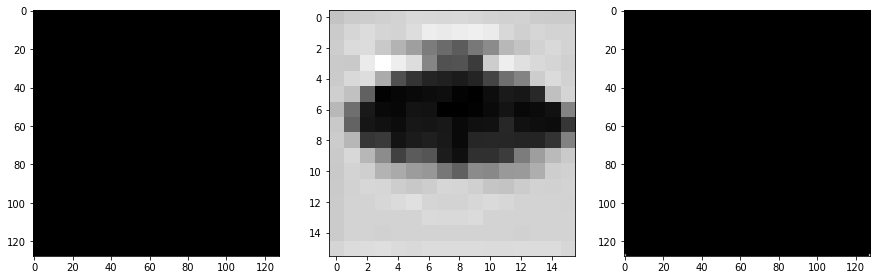

In [11]:
z_index = 4
fig, ax = plt.subplots(ncols=3)
plot_slice(original[batch_index, :], z_index, ax[0])
plot_slice(encoder_out[batch_index, :], encoder_out.shape[1] // 3, ax[1])
plot_slice(decoder_out[batch_index, :], z_index, ax[2])